# Load Dependencies

In [2]:
import logging
import sklearn
import torch
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
from rxnfp.models import SmilesClassificationModel
from data import generate_buchwald_hartwig_rxns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
import numpy as np
import os
from IPython.display import display
%matplotlib inline
torch.cuda.is_available()

This extension has only been tested with simpletransformers==0.34.4


True

In [4]:
def load_model_from_results_folder(name, split, epoch=10, results_folder='../trained_models/buchwald_hartwig', model_type='bert'):
    import os
    
    models_folder = os.path.join(results_folder, f"{name}_split_{str(split).replace('-','_')}")
    model_path = [os.path.join(models_folder, o) for o in os.listdir(models_folder) 
                        if os.path.isdir(os.path.join(models_folder,o)) and o.endswith(f'epoch-{epoch}')][0]
    
    
    model = SmilesClassificationModel(model_type, model_path,
                                  num_labels=1, args={
                                      "regression": True
                                  }, use_cuda=torch.cuda.is_available())
    return model

def make_plot(y_test, y_pred, rsme, r2_score, mae, name):
    fontsize = 16
    fig, ax = plt.subplots(figsize=(8,8))
    r2_patch = mpatches.Patch(label="R2 = {:.3f}".format(r2_score), color="#5402A3")
    rmse_patch = mpatches.Patch(label="RMSE = {:.1f}".format(rmse), color="#5402A3")
    mae_patch = mpatches.Patch(label="MAE = {:.1f}".format(mae), color="#5402A3")
    plt.xlim(-5,105)
    plt.ylim(-5,105)
    plt.scatter(y_pred, y_test, alpha=0.2, color="#5402A3")
    plt.plot(np.arange(100), np.arange(100), ls="--", c=".3")
    plt.legend(handles=[r2_patch, rmse_patch, mae_patch], fontsize=fontsize)
    ax.set_ylabel('Measured', fontsize=fontsize)
    ax.set_xlabel('Predicted', fontsize=fontsize)
    ax.set_title(name, fontsize=fontsize)
    return fig

# lig

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/1977 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

lig | R2 0.39 | RMSE 20.0 | MAE 13.1


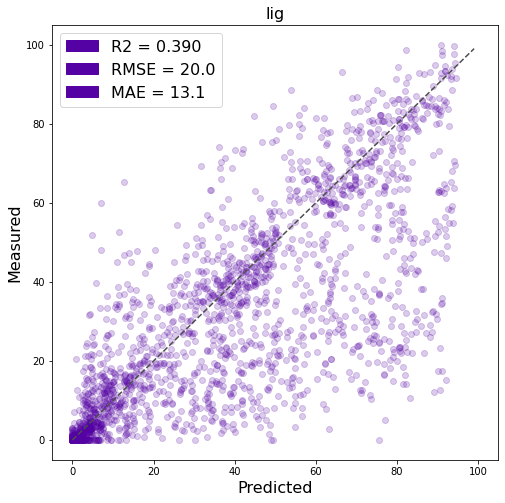

In [20]:
# data
NAME_SPLIT=NAME_SPLIT = [('lig', 1979)]
y_predictions = []
y_tests = []
r2_scores = []
rmse_scores = []

for (name, split) in NAME_SPLIT:

    df_doyle = pd.read_excel('../data/Buchwald-Hartwig/Dreher_and_Doyle_input_data_new.xlsx', sheet_name=name)

    df_doyle['rxn'] = generate_buchwald_hartwig_rxns(df_doyle)

    train_df = df_doyle.iloc[:split-1][['rxn', 'Output']] # paper has starting index 1 not 0
    test_df = df_doyle.iloc[split-1:][['rxn', 'Output']] # paper has starting index 1 not 0

    train_df.columns = ['text', 'labels']
    test_df.columns = ['text', 'labels']
    
    y_test = test_df.labels.values

    mean = train_df.labels.mean()
    std = train_df.labels.std()


    model = SmilesClassificationModel(model_type='bert', model_name='../training_scripts/outputs_buchwald_hartwig_discovery_pretrained_lig_split_1979/checkpoint-1240-epoch-10',num_labels=1, args={"regression": True}, use_cuda=torch.cuda.is_available())
    
    
    
    #load_model_from_results_folder(name, split,results_folder='../training_scripts')
    
    y_preds = model.predict(test_df.text.values)[0]
    
    y_preds = y_preds * std + mean
    
    y_preds = np.clip(y_preds, 0, 100)
    
    r_squared = r2_score(y_test, y_preds)
    rmse = mean_squared_error(y_test, y_preds) ** 0.5
    mae = mean_absolute_error(y_test, y_preds)
    
    r2_scores.append(r_squared)
    
    print(f"{name} | R2 {r_squared:.2f} | RMSE {rmse:.1f} | MAE {mae:.1f}")
    fig = make_plot(y_test, y_preds, rmse, r_squared, mae, name)
        
    # fig.savefig(f'images/mlst_doyle_results/{name}_{split}.pdf')
    

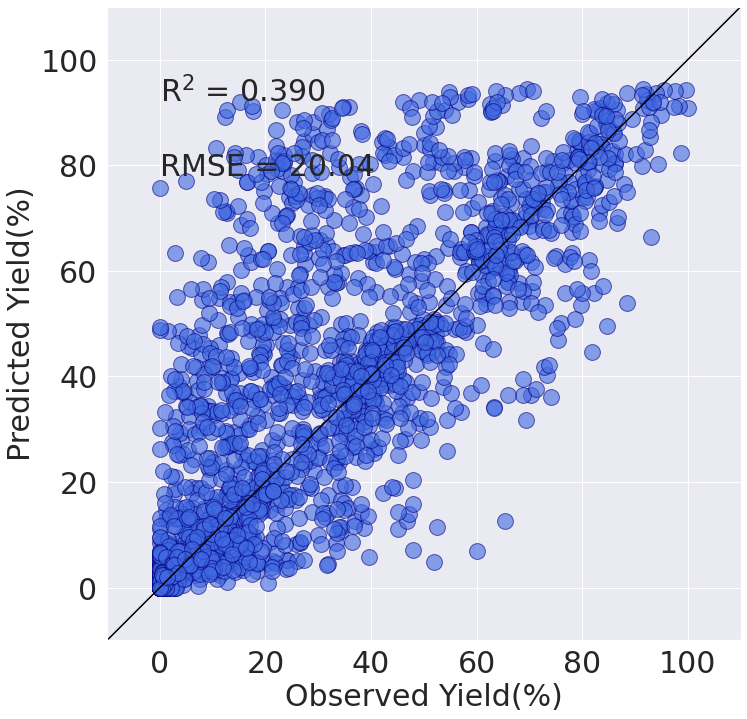

In [29]:
y_val=y_test
y_pred=y_preds
sns.set(style='darkgrid')


fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')#royalblue
plt.plot([-20,120],[-20,120],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
#ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=30)
plt.ylabel("Predicted Yield(%)",fontsize=30)
plt.tick_params(labelsize=30)
plt.text(0,78,'RMSE = %.2f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(0,92,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

# base

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/1321 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

base | R2 0.39 | RMSE 19.4 | MAE 12.7


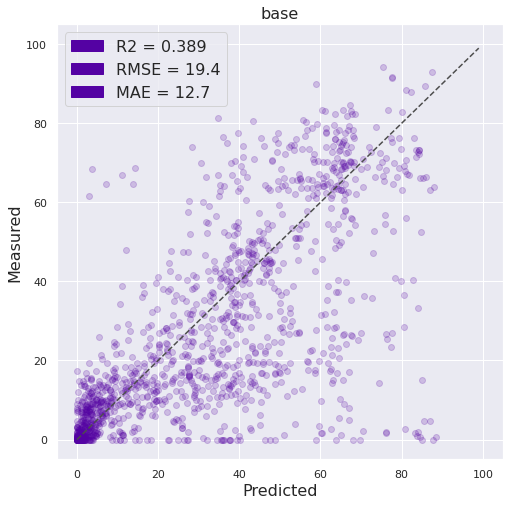

In [31]:
# data
NAME_SPLIT=NAME_SPLIT = [('base', 2635)]
y_predictions = []
y_tests = []
r2_scores = []
rmse_scores = []

for (name, split) in NAME_SPLIT:

    df_doyle = pd.read_excel('../data/Buchwald-Hartwig/Dreher_and_Doyle_input_data_new.xlsx', sheet_name=name)

    df_doyle['rxn'] = generate_buchwald_hartwig_rxns(df_doyle)

    train_df = df_doyle.iloc[:split-1][['rxn', 'Output']] # paper has starting index 1 not 0
    test_df = df_doyle.iloc[split-1:][['rxn', 'Output']] # paper has starting index 1 not 0

    train_df.columns = ['text', 'labels']
    test_df.columns = ['text', 'labels']
    
    y_test = test_df.labels.values

    mean = train_df.labels.mean()
    std = train_df.labels.std()


    model = SmilesClassificationModel(model_type='bert', model_name='../training_scripts/outputs_buchwald_hartwig_discovery_pretrained_base_split_2635/checkpoint-1650-epoch-10',num_labels=1, args={"regression": True}, use_cuda=torch.cuda.is_available())
    
    
    
    #load_model_from_results_folder(name, split,results_folder='../training_scripts')
    
    y_preds = model.predict(test_df.text.values)[0]
    
    y_preds = y_preds * std + mean
    
    y_preds = np.clip(y_preds, 0, 100)
    
    r_squared = r2_score(y_test, y_preds)
    rmse = mean_squared_error(y_test, y_preds) ** 0.5
    mae = mean_absolute_error(y_test, y_preds)
    
    r2_scores.append(r_squared)
    
    print(f"{name} | R2 {r_squared:.2f} | RMSE {rmse:.1f} | MAE {mae:.1f}")
    fig = make_plot(y_test, y_preds, rmse, r_squared, mae, name)
        
    # fig.savefig(f'images/mlst_doyle_results/{name}_{split}.pdf')
    

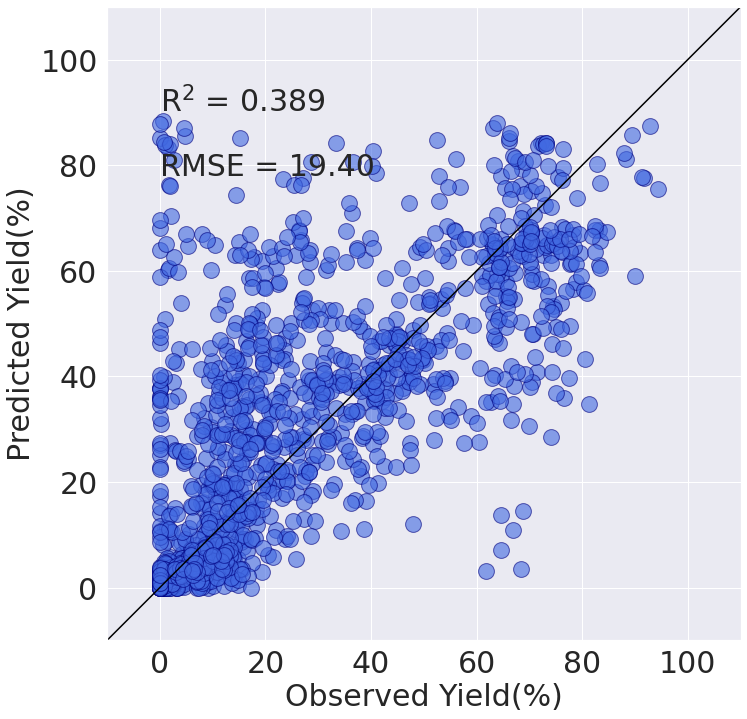

In [32]:
y_val=y_test
y_pred=y_preds
sns.set(style='darkgrid')


fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')#royalblue
plt.plot([-20,120],[-20,120],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
#ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=30)
plt.ylabel("Predicted Yield(%)",fontsize=30)
plt.tick_params(labelsize=30)
plt.text(0,78,'RMSE = %.2f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(0,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

# ar_ha

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/1584 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

ar_ha | R2 0.23 | RMSE 26.0 | MAE 20.0


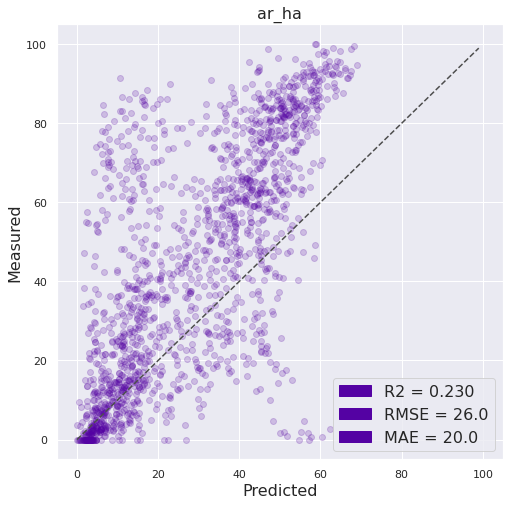

In [34]:
# data
NAME_SPLIT=NAME_SPLIT = [('ar_ha', 2372)]
y_predictions = []
y_tests = []
r2_scores = []
rmse_scores = []

for (name, split) in NAME_SPLIT:

    df_doyle = pd.read_excel('../data/Buchwald-Hartwig/Dreher_and_Doyle_input_data_new.xlsx', sheet_name=name)

    df_doyle['rxn'] = generate_buchwald_hartwig_rxns(df_doyle)

    train_df = df_doyle.iloc[:split-1][['rxn', 'Output']] # paper has starting index 1 not 0
    test_df = df_doyle.iloc[split-1:][['rxn', 'Output']] # paper has starting index 1 not 0

    train_df.columns = ['text', 'labels']
    test_df.columns = ['text', 'labels']
    
    y_test = test_df.labels.values

    mean = train_df.labels.mean()
    std = train_df.labels.std()


    model = SmilesClassificationModel(model_type='bert', model_name='../training_scripts/outputs_buchwald_hartwig_discovery_pretrained_ar_ha_split_2372/checkpoint-1490-epoch-10',num_labels=1, args={"regression": True}, use_cuda=torch.cuda.is_available())
    
    
    
    #load_model_from_results_folder(name, split,results_folder='../training_scripts')
    
    y_preds = model.predict(test_df.text.values)[0]
    
    y_preds = y_preds * std + mean
    
    y_preds = np.clip(y_preds, 0, 100)
    
    r_squared = r2_score(y_test, y_preds)
    rmse = mean_squared_error(y_test, y_preds) ** 0.5
    mae = mean_absolute_error(y_test, y_preds)
    
    r2_scores.append(r_squared)
    
    print(f"{name} | R2 {r_squared:.2f} | RMSE {rmse:.1f} | MAE {mae:.1f}")
    fig = make_plot(y_test, y_preds, rmse, r_squared, mae, name)
        
    # fig.savefig(f'images/mlst_doyle_results/{name}_{split}.pdf')
    

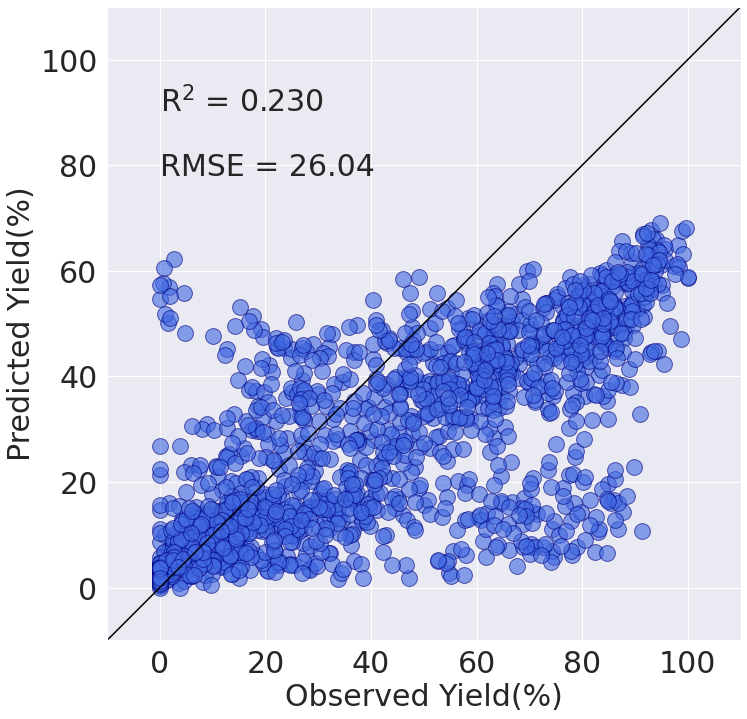

In [35]:
y_val=y_test
y_pred=y_preds
sns.set(style='darkgrid')


fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')#royalblue
plt.plot([-20,120],[-20,120],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
#ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=30)
plt.ylabel("Predicted Yield(%)",fontsize=30)
plt.tick_params(labelsize=30)
plt.text(0,78,'RMSE = %.2f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(0,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

# add

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/1981 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

add | R2 0.37 | RMSE 21.3 | MAE 14.3


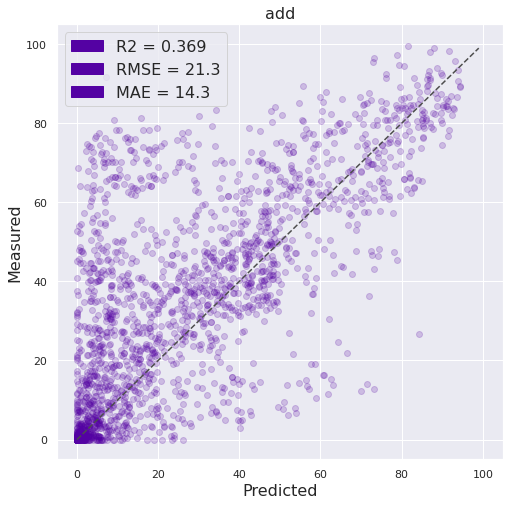

In [37]:
# data
NAME_SPLIT=NAME_SPLIT = [('add', 1975)]
y_predictions = []
y_tests = []
r2_scores = []
rmse_scores = []

for (name, split) in NAME_SPLIT:

    df_doyle = pd.read_excel('../data/Buchwald-Hartwig/Dreher_and_Doyle_input_data_new.xlsx', sheet_name=name)

    df_doyle['rxn'] = generate_buchwald_hartwig_rxns(df_doyle)

    train_df = df_doyle.iloc[:split-1][['rxn', 'Output']] # paper has starting index 1 not 0
    test_df = df_doyle.iloc[split-1:][['rxn', 'Output']] # paper has starting index 1 not 0

    train_df.columns = ['text', 'labels']
    test_df.columns = ['text', 'labels']
    
    y_test = test_df.labels.values

    mean = train_df.labels.mean()
    std = train_df.labels.std()


    model = SmilesClassificationModel(model_type='bert', model_name='../training_scripts/outputs_buchwald_hartwig_discovery_pretrained_add_split_1975/checkpoint-1240-epoch-10',num_labels=1, args={"regression": True}, use_cuda=torch.cuda.is_available())
    
    
    
    #load_model_from_results_folder(name, split,results_folder='../training_scripts')
    
    y_preds = model.predict(test_df.text.values)[0]
    
    y_preds = y_preds * std + mean
    
    y_preds = np.clip(y_preds, 0, 100)
    
    r_squared = r2_score(y_test, y_preds)
    rmse = mean_squared_error(y_test, y_preds) ** 0.5
    mae = mean_absolute_error(y_test, y_preds)
    
    r2_scores.append(r_squared)
    
    print(f"{name} | R2 {r_squared:.2f} | RMSE {rmse:.1f} | MAE {mae:.1f}")
    fig = make_plot(y_test, y_preds, rmse, r_squared, mae, name)
        
    # fig.savefig(f'images/mlst_doyle_results/{name}_{split}.pdf')
    

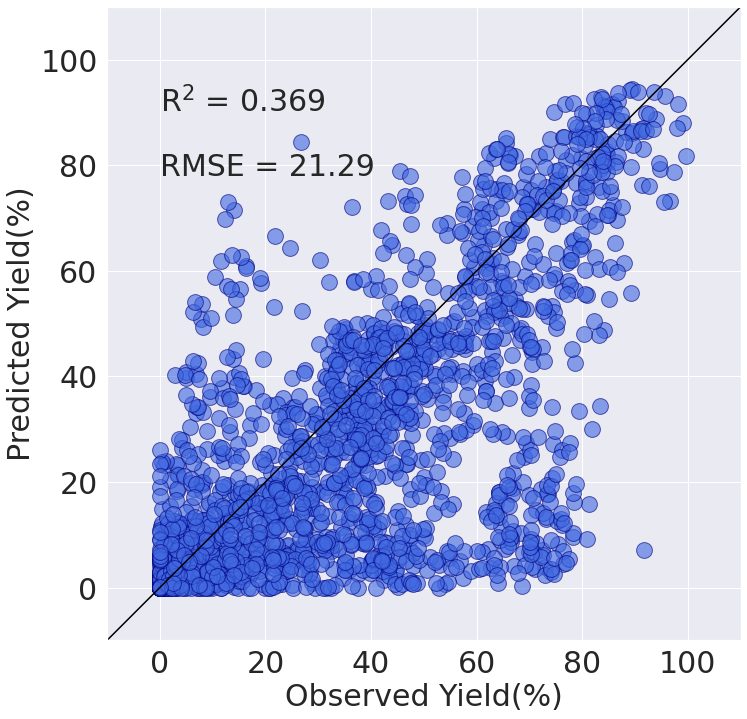

In [38]:
y_val=y_test
y_pred=y_preds
sns.set(style='darkgrid')


fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')#royalblue
plt.plot([-20,120],[-20,120],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
#ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=30)
plt.ylabel("Predicted Yield(%)",fontsize=30)
plt.tick_params(labelsize=30)
plt.text(0,78,'RMSE = %.2f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(0,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()